In [9]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from itertools import combinations
from collections import OrderedDict
import os



def load_train_test_data(base_path):
    def load_data(folder_path):
        df_list = []
        for entry in os.listdir(folder_path):
            class_label = entry.split('_')[0]
            file_path = os.path.join(folder_path, entry)
            temp_df = pd.read_csv(file_path, sep=' ', names=['Feature1', 'Feature2'])
            temp_df['Class'] = class_label
            df_list.append(temp_df)
        return pd.concat(df_list, ignore_index=True)

    train_path = os.path.join(base_path, "train")
    test_path = os.path.join(base_path, "test")

    train_df = load_data(train_path)
    test_df = load_data(test_path)

    return train_df, test_df

# -------------------------
# Matrix & small-linalg helpers (2x2)
# -------------------------
def det2x2(M):
    return M[0][0]*M[1][1] - M[0][1]*M[1][0]

def inv2x2(M):
    d = det2x2(M)
    if abs(d) < 1e-12:
        eps = 1e-6
        M = [[M[0][0] + eps, M[0][1]], [M[1][0], M[1][1] + eps]]
        d = det2x2(M)
        if abs(d) < 1e-12:
            raise ValueError("Matrix not invertible")
    return [[ M[1][1]/d, -M[0][1]/d],
            [-M[1][0]/d,  M[0][0]/d]]

def matvec(M, v):
    return [M[0][0]*v[0] + M[0][1]*v[1],
            M[1][0]*v[0] + M[1][1]*v[1]]

def dot(u, v):
    return u[0]*v[0] + u[1]*v[1]

def eig_2x2_symmetric(M):
    # M = [[a,b],[b,c]]
    a = M[0][0]; b = M[0][1]; c = M[1][1]
    tr = a + c
    disc = tr*tr - 4*(a*c - b*b)
    disc = max(disc, 0.0)
    sqrt_disc = math.sqrt(disc)
    l1 = (tr + sqrt_disc) / 2.0
    l2 = (tr - sqrt_disc) / 2.0
    def vec_for(l):
        if abs(b) > 1e-12:
            v = [-b, a - l]
            norm = math.sqrt(v[0]*v[0] + v[1]*v[1])
            return [v[0]/norm, v[1]/norm] if norm>0 else [1.0,0.0]
        else:
            # diagonal matrix
            if abs(a - l) < abs(c - l):
                return [1.0, 0.0]
            else:
                return [0.0, 1.0]
    v1 = vec_for(l1)
    v2 = vec_for(l2)
    return (l1, v1), (l2, v2)

# -------------------------
# Statistics from training set
# -------------------------
def compute_class_means_and_priors(train_df):
    class_means = {}
    priors = {}
    total = len(train_df)
    for cls in train_df['Class'].unique():
        subset = train_df[train_df['Class'] == cls]
        f1 = subset['Feature1'].tolist()
        f2 = subset['Feature2'].tolist()
        mean1 = sum(f1)/len(f1)
        mean2 = sum(f2)/len(f2)
        class_means[cls] = [mean1, mean2]
        priors[cls] = len(subset)/total
    return class_means, priors

def covariance_matrix(df):
    x = df['Feature1'].tolist()
    y = df['Feature2'].tolist()
    n = len(x)
    mx = sum(x)/n
    my = sum(y)/n
    varx = sum((xi-mx)**2 for xi in x)/(n)
    vary = sum((yi-my)**2 for yi in y)/(n)
    covxy = sum((xi-mx)*(yi-my) for xi,yi in zip(x,y))/(n)
    return [[varx, covxy],[covxy, vary]]

def compute_class_covariances(train_df):
    covs = OrderedDict()
    for cls in train_df['Class'].unique():
        subset = train_df[train_df['Class'] == cls]
        covs[cls] = covariance_matrix(subset)
    return covs

# -------------------------
# Generic Discriminant & Predict (Gaussian Bayes form)
# -------------------------
def discriminant_score(x, mu, Sigma, prior):
    Sigma_inv = inv2x2(Sigma)
    detS = det2x2(Sigma)
    if detS <= 0:
        # tiny ridge
        eps = 1e-6
        Sigma = [[Sigma[0][0]+eps, Sigma[0][1]],[Sigma[1][0], Sigma[1][1]+eps]]
        Sigma_inv = inv2x2(Sigma)
        detS = det2x2(Sigma)
    diff = [x[0]-mu[0], x[1]-mu[1]]
    qf = dot(diff, matvec(Sigma_inv, diff))
    return -0.5 * qf - 0.5 * math.log(detS) + math.log(prior)

def predict_with_params(test_df, means, priors, covs, shared=False, diagonal=False):
    preds = []
    for _, row in test_df.iterrows():
        x = [row['Feature1'], row['Feature2']]
        scores = {}
        for cls in means:
            mu = means[cls]
            Sigma = covs["shared"] if shared else covs[cls]
            if diagonal:
                Sigma = [[Sigma[0][0], 0.0], [0.0, Sigma[1][1]]]
            scores[cls] = discriminant_score(x, mu, Sigma, priors[cls])
        preds.append(max(scores, key=scores.get))
    return preds

# ---------------
# Classifier wrappers
# ---------------
def classifier_sigma2I(train_df, test_df):
    means, priors = compute_class_means_and_priors(train_df)
    covs = compute_class_covariances(train_df)
    # average of variances
    allvars = []
    for C in covs.values():
        allvars.append(C[0][0]); allvars.append(C[1][1])
    sigma2 = sum(allvars)/len(allvars)
    cov_shared = [[sigma2, 0.0], [0.0, sigma2]]
    covs_shared = {"shared": cov_shared}
    return predict_with_params(test_df, means, priors, covs_shared, shared=True)

def classifier_shared_full(train_df, test_df):
    means, priors = compute_class_means_and_priors(train_df)
    covs = compute_class_covariances(train_df)
    n = len(covs)
    s = [[0.0,0.0],[0.0,0.0]]
    for C in covs.values():
        s[0][0] += C[0][0]; s[0][1] += C[0][1]
        s[1][0] += C[1][0]; s[1][1] += C[1][1]
    shared = [[s[i][j]/n for j in range(2)] for i in range(2)]
    return predict_with_params(test_df, *compute_class_means_and_priors(train_df), {"shared": shared}, shared=True)

def classifier_diag_per_class(train_df, test_df):
    means, priors = compute_class_means_and_priors(train_df)
    covs = compute_class_covariances(train_df)
    return predict_with_params(test_df, means, priors, covs, diagonal=True)

def classifier_full_per_class(train_df, test_df):
    means, priors = compute_class_means_and_priors(train_df)
    covs = compute_class_covariances(train_df)
    return predict_with_params(test_df, means, priors, covs)

# -------------------------
# Evaluation utilities
# -------------------------
def confusion_matrix(true_labels, pred_labels):
    labels = sorted(set(true_labels) | set(pred_labels))
    cm = {l: {k:0 for k in labels} for l in labels}
    for t,p in zip(true_labels, pred_labels):
        cm[t][p] += 1
    return labels, cm

def classification_report_print(true_labels, pred_labels):
    labels, cm = confusion_matrix(true_labels, pred_labels)
    total = len(true_labels)
    print("\n=== Confusion Matrix ===")
    hdr = "\t" + "\t".join(labels)
    print(hdr)
    for l in labels:
        row = [str(cm[l][p]) for p in labels]
        print(l + "\t" + "\t".join(row))
    # metrics
    print("\n=== Classification Report ===")
    print("Class\tPrecision\tRecall\tF1-score\tSupport")
    precisions = []
    recalls = []
    f1s = []
    supports = []
    for l in labels:
        tp = cm[l][l]
        fp = sum(cm[other][l] for other in labels if other!=l)
        fn = sum(cm[l][other] for other in labels if other!=l)
        support = tp + fn
        prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec = tp/(tp+fn) if (tp+fn)>0 else 0.0
        f1 = (2*prec*rec/(prec+rec)) if (prec+rec)>0 else 0.0
        print(f"{l}\t{prec:.4f}\t\t{rec:.4f}\t{f1:.4f}\t\t{support}")
        precisions.append(prec); recalls.append(rec); f1s.append(f1); supports.append(support)
    mean_prec = sum(precisions)/len(precisions) if precisions else 0
    mean_rec = sum(recalls)/len(recalls) if recalls else 0
    mean_f1 = sum(f1s)/len(f1s) if f1s else 0
    acc = sum(cm[l][l] for l in labels)/total if total>0 else 0
    print(f"\nAccuracy: {acc:.4f}")
    print(f"Mean Precision: {mean_prec:.4f}")
    print(f"Mean Recall   : {mean_rec:.4f}")
    print(f"Mean F1 Score : {mean_f1:.4f}")
    return labels, cm

# pretty heatmap of confusion matrix
def plot_confusion_matrix_heatmap(labels, cm, title="Confusion Matrix"):
    # create 2D numeric grid
    grid = [[cm[row][col] for col in labels] for row in labels]
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(grid, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    plt.colorbar(im, ax=ax)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_title(title)
    # annotate
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, str(grid[i][j]), ha="center", va="center", color="black")
    plt.tight_layout()
    plt.show()

# -------------------------
# Plot: training scatter (start)
# -------------------------
def plot_training_scatter(train_df, title="Training Data Scatter"):
    plt.figure(figsize=(8,6))
    markers = ['o','s','^','x','D','P','*']
    labels = train_df['Class'].unique()
    for i, cls in enumerate(labels):
        sub = train_df[train_df['Class']==cls]
        plt.scatter(sub['Feature1'], sub['Feature2'], marker=markers[i%len(markers)], label=cls, edgecolor='k', alpha=0.8)
    plt.xlabel("Feature1"); plt.ylabel("Feature2"); plt.title(title); plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------
# Plot constant-density Gaussian contours (1σ,2σ,3σ)
# -------------------------
def plot_density_contours(train_df, class_means, class_covs, title="Constant Density Contours (1σ,2σ,3σ)"):
    plt.figure(figsize=(8,6))
    colors = ["red","blue","green","purple","orange","brown","cyan"]
    labels = list(class_means.keys())
    for idx, cls in enumerate(labels):
        sub = train_df[train_df['Class']==cls]
        plt.scatter(sub['Feature1'], sub['Feature2'], label=cls, alpha=0.6, marker='o', edgecolor='k')
        mu = class_means[cls]
        cov = class_covs[cls]
        (l1,v1),(l2,v2) = eig_2x2_symmetric(cov)
        l1 = max(l1, 1e-6); l2 = max(l2, 1e-6)
        angle = math.degrees(math.atan2(v1[1], v1[0]))
        for scale in [1,2,3]:
            width = 2*scale*math.sqrt(l1)
            height = 2*scale*math.sqrt(l2)
            e = Ellipse((mu[0], mu[1]), width, height, angle=angle, edgecolor=colors[idx%len(colors)], facecolor='none', linewidth=1.8, linestyle='--', alpha=0.8)
            plt.gca().add_patch(e)
    plt.xlabel("Feature1"); plt.ylabel("Feature2"); plt.title(title); plt.legend()
    plt.grid(True); plt.show()

# -------------------------
# Decision region plotting (pairwise and all-classes)
# -------------------------
def classify_point_all_methods(point, means, priors, covs, use_shared=False, diagonal=False):
    # returns predicted class label
    best = None; best_score = -1e99
    for cls in means:
        Sigma = covs["shared"] if use_shared else covs[cls]
        if diagonal:
            Sigma = [[Sigma[0][0], 0.0],[0.0, Sigma[1][1]]]
        score = discriminant_score(point, means[cls], Sigma, priors[cls])
        if best is None or score > best_score:
            best_score = score; best = cls
    return best

def decision_region_grid(train_df, means, priors, covs, shared=False, diagonal=False, res=200):
    # build grid
    x_min = train_df['Feature1'].min() - 1.0
    x_max = train_df['Feature1'].max() + 1.0
    y_min = train_df['Feature2'].min() - 1.0
    y_max = train_df['Feature2'].max() + 1.0
    xs = [x_min + i*(x_max-x_min)/(res-1) for i in range(res)]
    ys = [y_min + j*(y_max-y_min)/(res-1) for j in range(res)]
    labels = list(means.keys())
    label_to_int = {lab:i for i,lab in enumerate(labels)}
    Z = [[None]*res for _ in range(res)]
    for i,x in enumerate(xs):
        for j,y in enumerate(ys):
            pred = classify_point_all_methods([x,y], means, priors, covs, use_shared=shared, diagonal=diagonal)
            Z[j][i] = label_to_int[pred]
    return xs, ys, Z, labels

def plot_decision_regions(train_df, means, priors, covs, shared=False, diagonal=False, title="Decision Regions", res=200):
    xs, ys, Z, labels = decision_region_grid(train_df, means, priors, covs, shared=shared, diagonal=diagonal, res=res)
    plt.figure(figsize=(8,6))
    import numpy as _np  
    X, Y = _np.meshgrid(xs, ys)
    cmap = plt.get_cmap('Pastel1')
    Z_arr = _np.array(Z)
    plt.pcolormesh(X, Y, Z_arr, shading='auto', cmap=cmap, alpha=0.4)
    markers = ['o','s','^','x','D','P','*']
    for i, lab in enumerate(labels):
        sub = train_df[train_df['Class']==lab]
        plt.scatter(sub['Feature1'], sub['Feature2'], marker=markers[i%len(markers)], label=lab, edgecolor='k')
    plt.title(title); plt.xlabel("Feature1"); plt.ylabel("Feature2"); plt.legend(); plt.show()

# -------------------------
# Main routine to run everything for a dataset
# -------------------------
def run_all(train_df, test_df, res=200):
    plot_training_scatter(train_df, title="Training Data - Scatter (Start)")

    means, priors = compute_class_means_and_priors(train_df)
    class_covs = compute_class_covariances(train_df)

    plot_density_contours(train_df, means, class_covs)

    classifiers = {
        "sigma2I": (classifier_sigma2I, {"shared":True, "diagonal":False}),
        "shared_full": (classifier_shared_full, {"shared":True, "diagonal":False}),
        "diag_per_class": (classifier_diag_per_class, {"shared":False, "diagonal":True}),
        "full_per_class": (classifier_full_per_class, {"shared":False, "diagonal":False})
    }

    for name, (func, flags) in classifiers.items():
        print("\n\n========================")
        print("Classifier:", name)
        preds = func(train_df, test_df)  
        colname = "Pred_" + name
        test_df[colname] = preds
        labels, cm = classification_report_print(test_df['Class'].tolist(), test_df[colname].tolist())
        plot_confusion_matrix_heatmap(labels, cm, title=f"Confusion Matrix - {name}")
        all_labels = list(means.keys())
        for (a,b) in combinations(all_labels, 2):
            reduced_train = train_df[train_df['Class'].isin([a,b])]
            reduced_means = {a: means[a], b: means[b]}
            reduced_priors = {a: priors[a], b: priors[b]}
            reduced_covs = {a: class_covs[a], b: class_covs[b]}
            if flags["shared"]:
                s = [[0.0,0.0],[0.0,0.0]]
                for C in reduced_covs.values():
                    s[0][0]+=C[0][0]; s[0][1]+=C[0][1]; s[1][0]+=C[1][0]; s[1][1]+=C[1][1]
                n = len(reduced_covs)
                reduced_covs = {"shared": [[s[0][0]/n, s[0][1]/n],[s[1][0]/n, s[1][1]/n]]}
            title = f"Decision Region ({name}) - {a} vs {b}"
            plot_decision_regions(reduced_train, reduced_means, reduced_priors, reduced_covs, shared=flags["shared"], diagonal=flags["diagonal"], title=title, res=res//2)

        if len(means) > 2:
            covs_for_plot = class_covs
            if flags["shared"]:
                s = [[0.0,0.0],[0.0,0.0]]
                for C in class_covs.values():
                    s[0][0]+=C[0][0]; s[0][1]+=C[0][1]; s[1][0]+=C[1][0]; s[1][1]+=C[1][1]
                n = len(class_covs)
                covs_for_plot = {"shared": [[s[0][0]/n, s[0][1]/n],[s[1][0]/n, s[1][1]/n]]}
            plot_decision_regions(train_df, means, priors, covs_for_plot, shared=flags["shared"], diagonal=flags["diagonal"], title=f"Decision Regions All Classes ({name})", res=res)

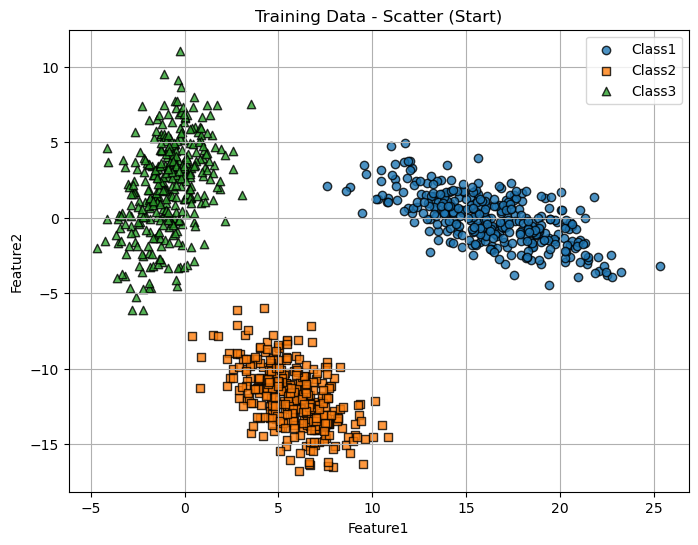

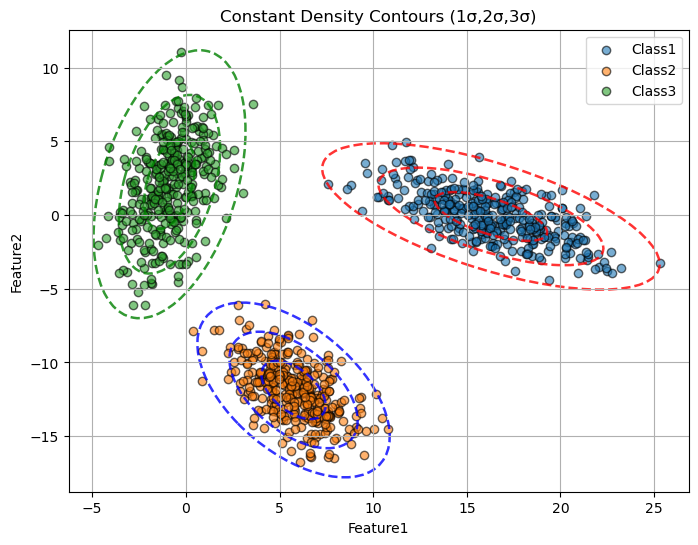



Classifier: sigma2I

=== Confusion Matrix ===
	Class1	Class2	Class3
Class1	148	0	2
Class2	0	150	0
Class3	0	0	150

=== Classification Report ===
Class	Precision	Recall	F1-score	Support
Class1	1.0000		0.9867	0.9933		150
Class2	1.0000		1.0000	1.0000		150
Class3	0.9868		1.0000	0.9934		150

Accuracy: 0.9956
Mean Precision: 0.9956
Mean Recall   : 0.9956
Mean F1 Score : 0.9956


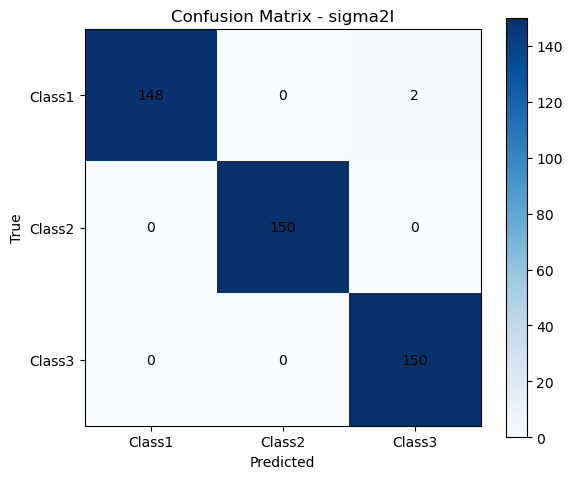

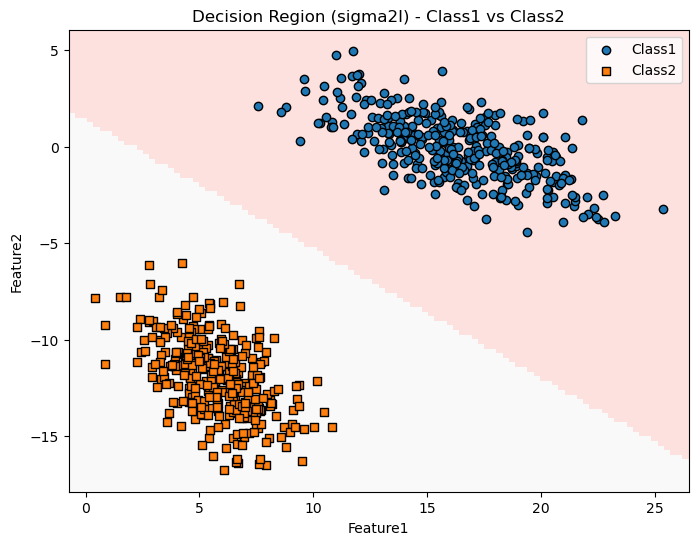

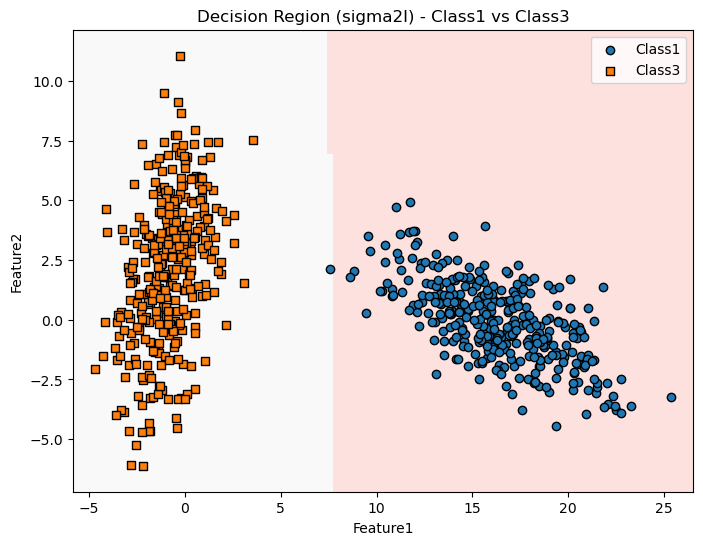

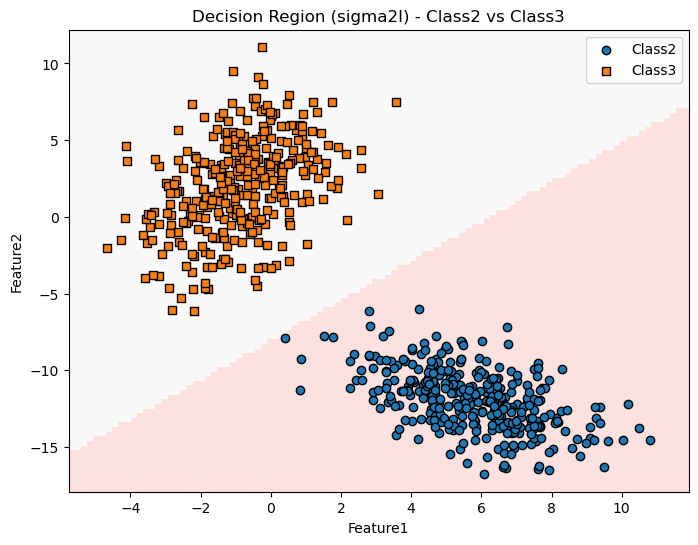

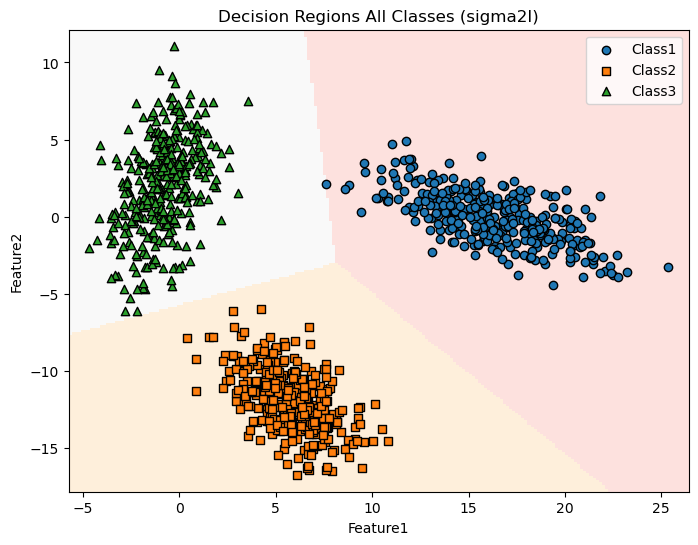



Classifier: shared_full

=== Confusion Matrix ===
	Class1	Class2	Class3
Class1	149	0	1
Class2	0	150	0
Class3	0	0	150

=== Classification Report ===
Class	Precision	Recall	F1-score	Support
Class1	1.0000		0.9933	0.9967		150
Class2	1.0000		1.0000	1.0000		150
Class3	0.9934		1.0000	0.9967		150

Accuracy: 0.9978
Mean Precision: 0.9978
Mean Recall   : 0.9978
Mean F1 Score : 0.9978


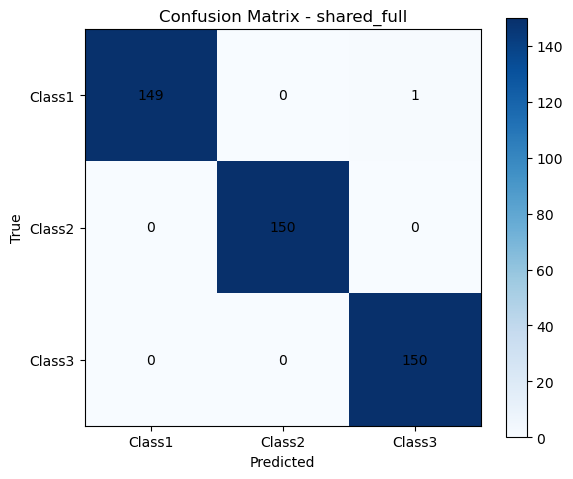

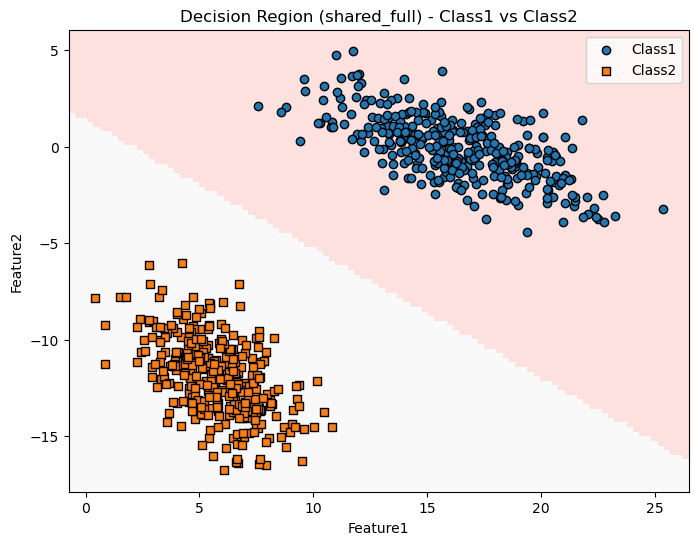

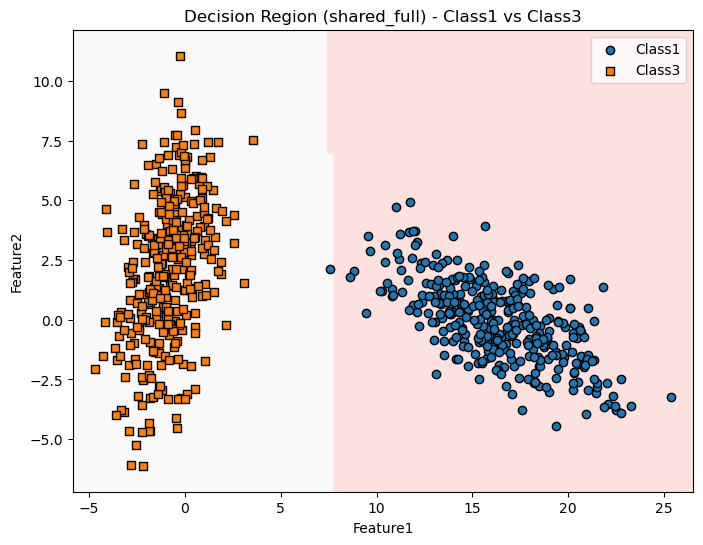

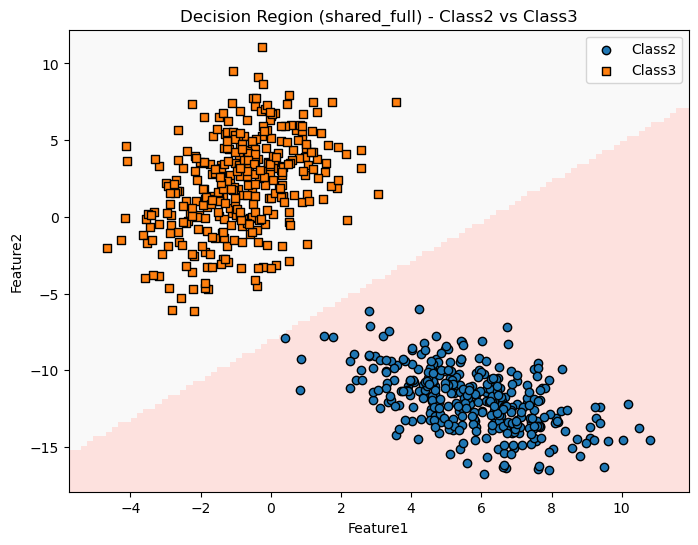

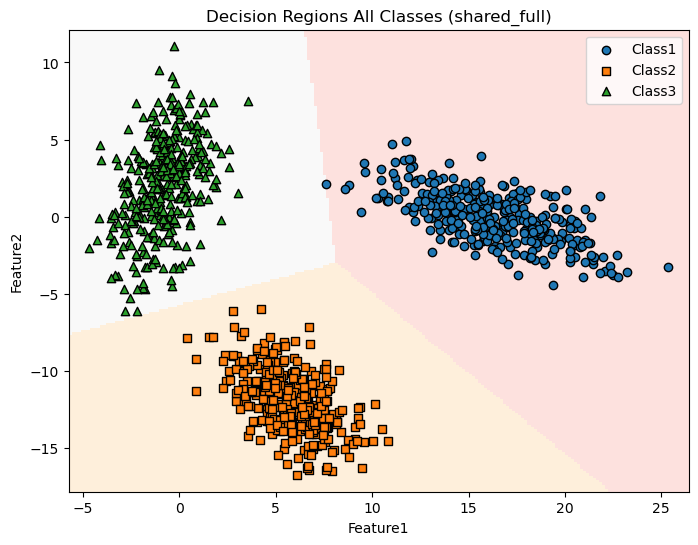



Classifier: diag_per_class

=== Confusion Matrix ===
	Class1	Class2	Class3
Class1	150	0	0
Class2	0	148	2
Class3	0	0	150

=== Classification Report ===
Class	Precision	Recall	F1-score	Support
Class1	1.0000		1.0000	1.0000		150
Class2	1.0000		0.9867	0.9933		150
Class3	0.9868		1.0000	0.9934		150

Accuracy: 0.9956
Mean Precision: 0.9956
Mean Recall   : 0.9956
Mean F1 Score : 0.9956


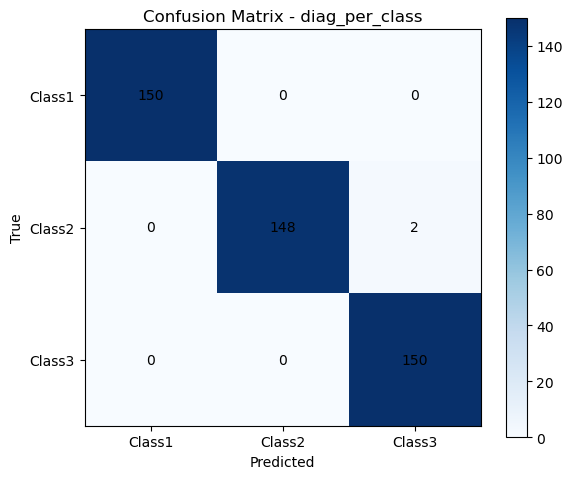

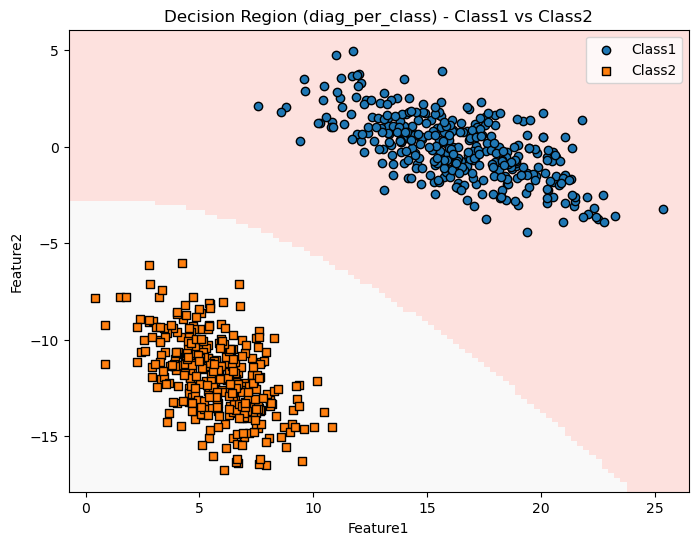

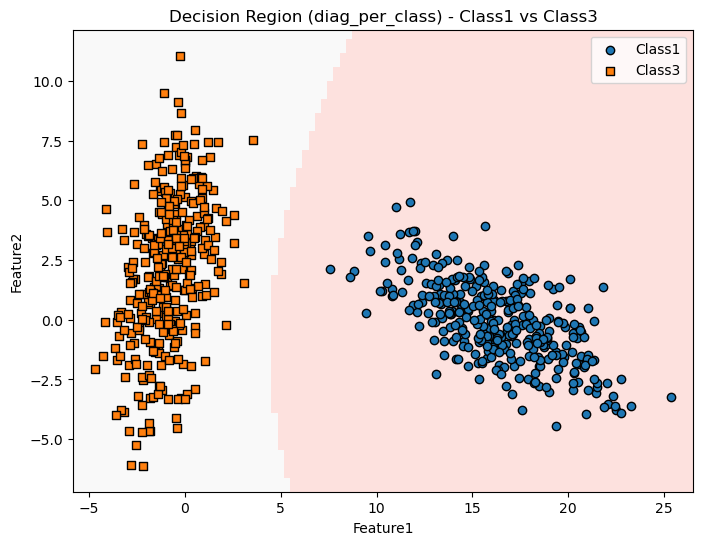

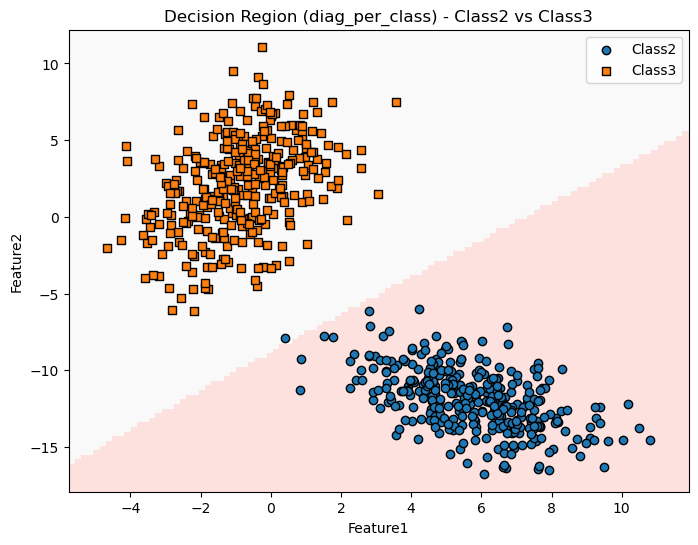

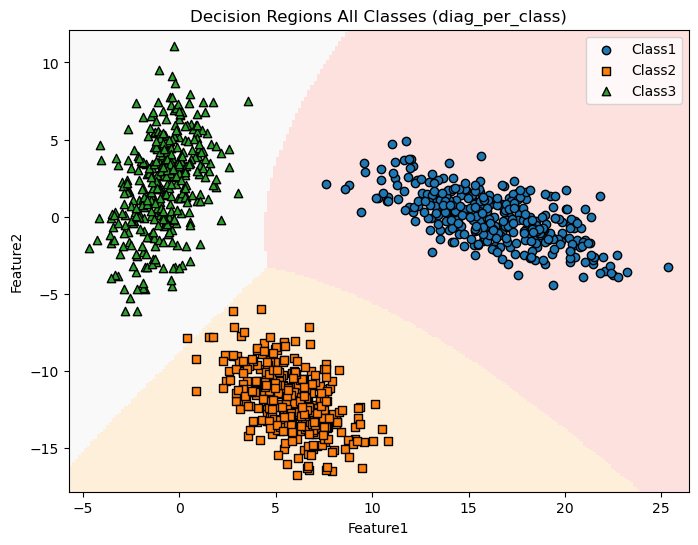



Classifier: full_per_class

=== Confusion Matrix ===
	Class1	Class2	Class3
Class1	150	0	0
Class2	0	150	0
Class3	0	0	150

=== Classification Report ===
Class	Precision	Recall	F1-score	Support
Class1	1.0000		1.0000	1.0000		150
Class2	1.0000		1.0000	1.0000		150
Class3	1.0000		1.0000	1.0000		150

Accuracy: 1.0000
Mean Precision: 1.0000
Mean Recall   : 1.0000
Mean F1 Score : 1.0000


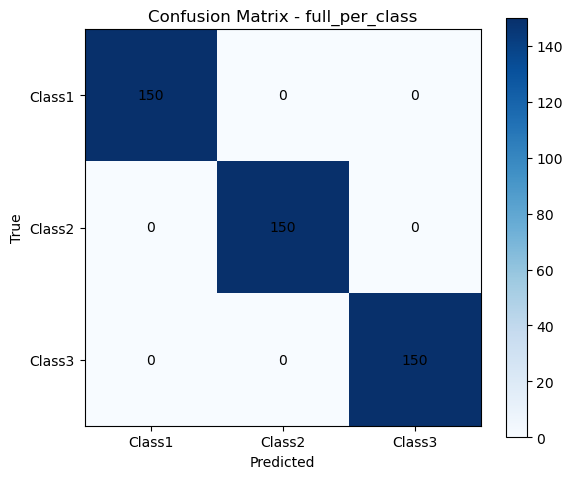

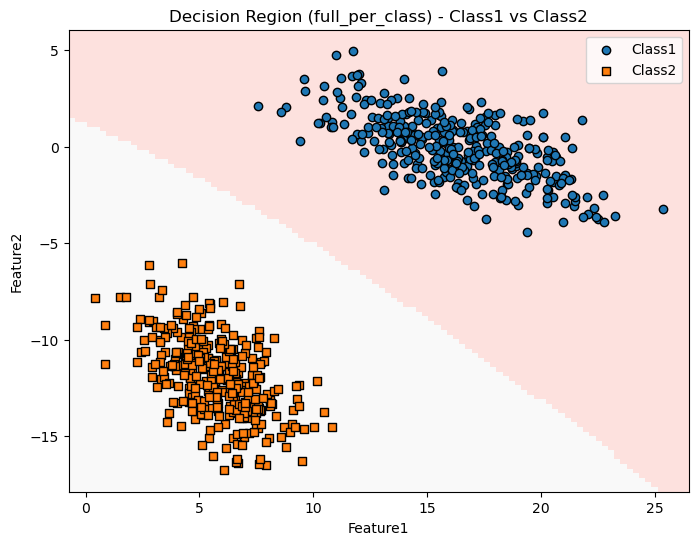

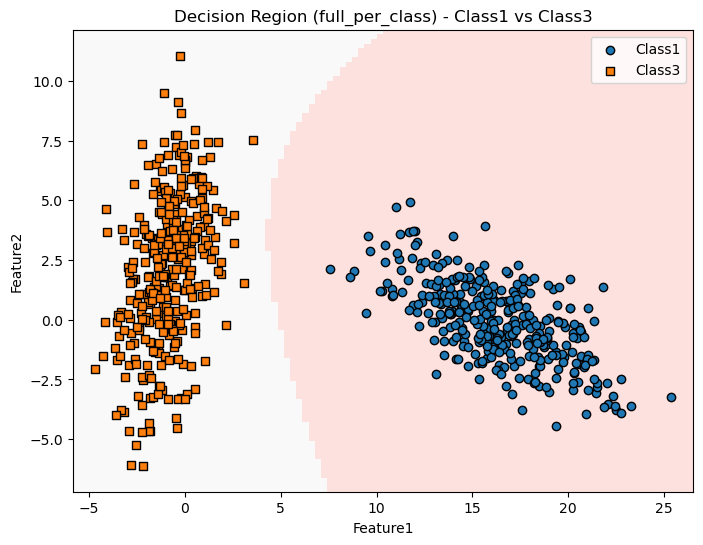

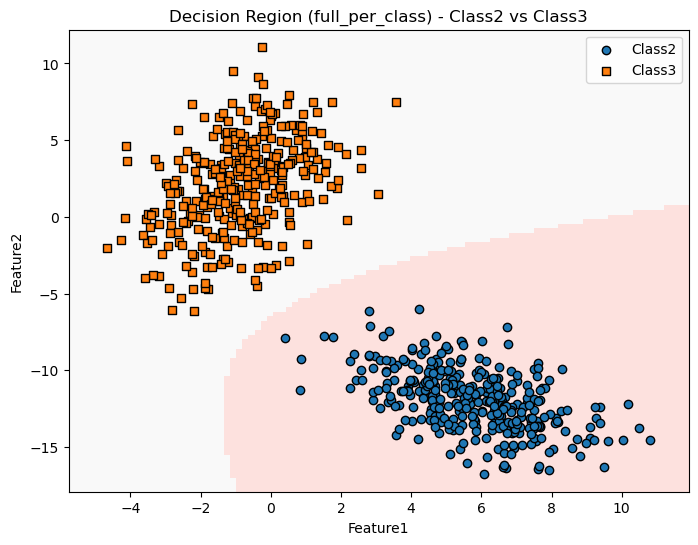

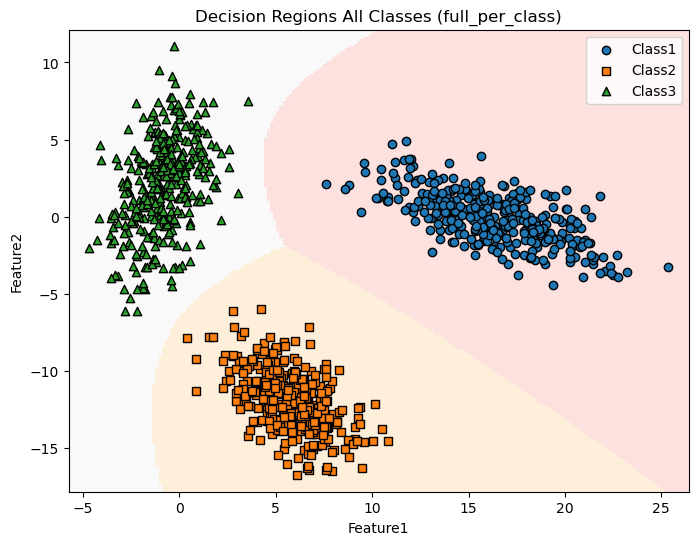

In [10]:
base_path = "../../Dataset/Group04/LS_Group04/"
# base_path = "../../Dataset/Group04/NLS_Group04/"
# base_path = "../../Dataset/Group04/rd_group4/"

train_df, test_df = load_train_test_data(base_path)
run_all(train_df, test_df, res=200)


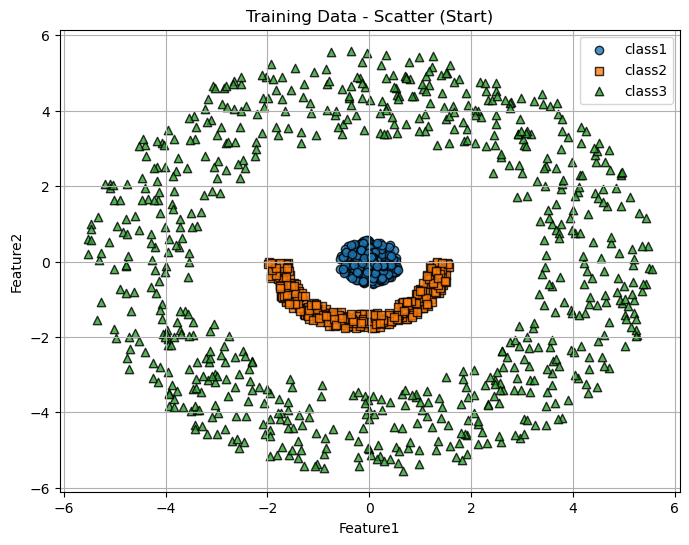

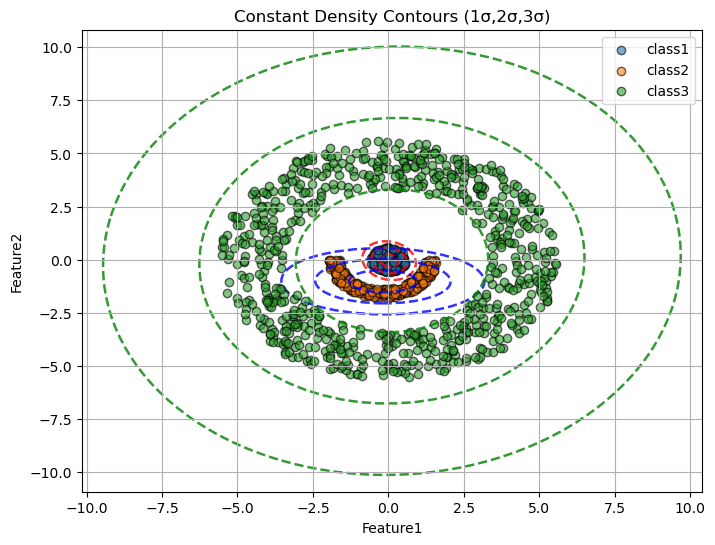



Classifier: sigma2I

=== Confusion Matrix ===
	class1	class2	class3
class1	0	0	90
class2	0	0	150
class3	0	77	223

=== Classification Report ===
Class	Precision	Recall	F1-score	Support
class1	0.0000		0.0000	0.0000		90
class2	0.0000		0.0000	0.0000		150
class3	0.4816		0.7433	0.5845		300

Accuracy: 0.4130
Mean Precision: 0.1605
Mean Recall   : 0.2478
Mean F1 Score : 0.1948


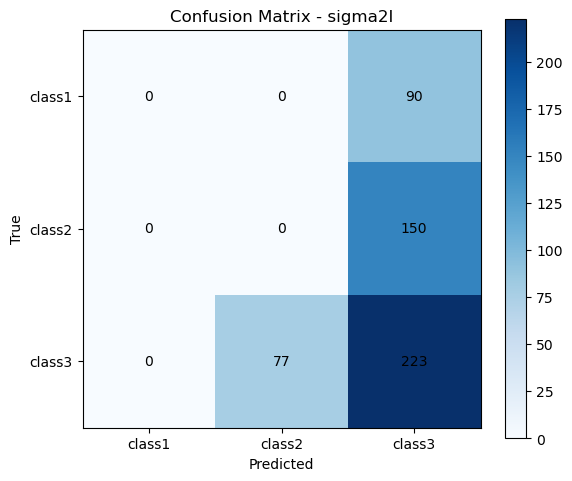

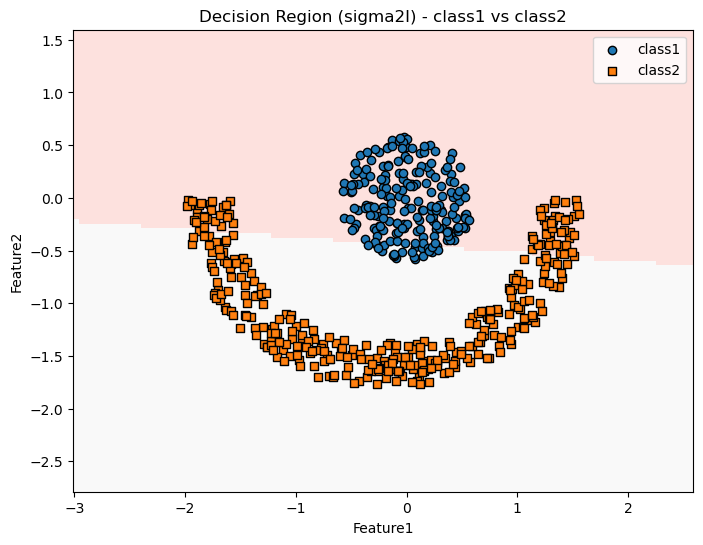

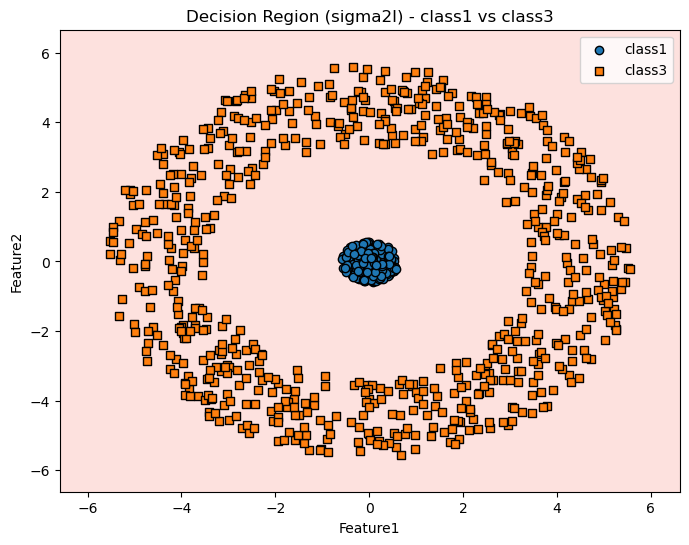

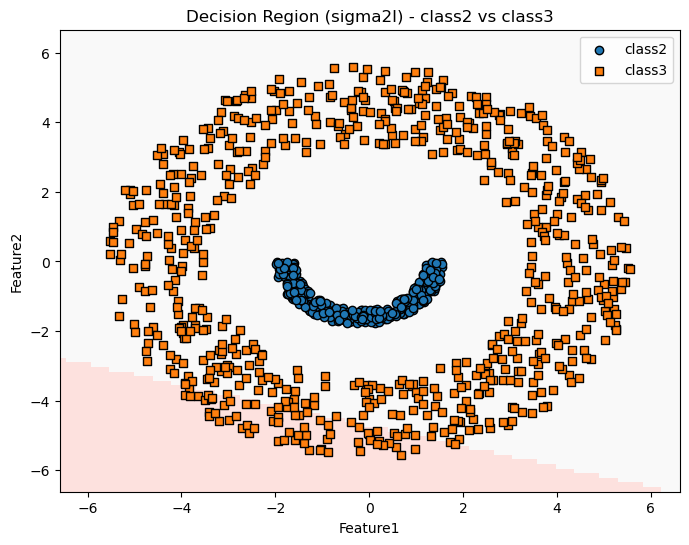

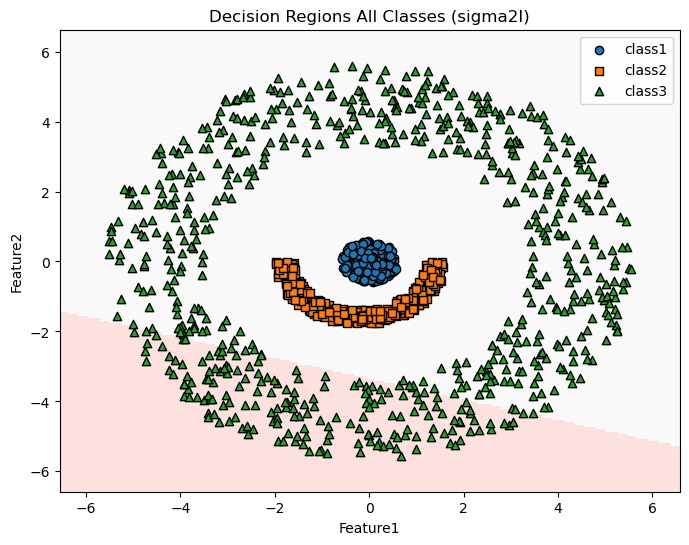



Classifier: shared_full

=== Confusion Matrix ===
	class1	class2	class3
class1	0	0	90
class2	0	0	150
class3	0	75	225

=== Classification Report ===
Class	Precision	Recall	F1-score	Support
class1	0.0000		0.0000	0.0000		90
class2	0.0000		0.0000	0.0000		150
class3	0.4839		0.7500	0.5882		300

Accuracy: 0.4167
Mean Precision: 0.1613
Mean Recall   : 0.2500
Mean F1 Score : 0.1961


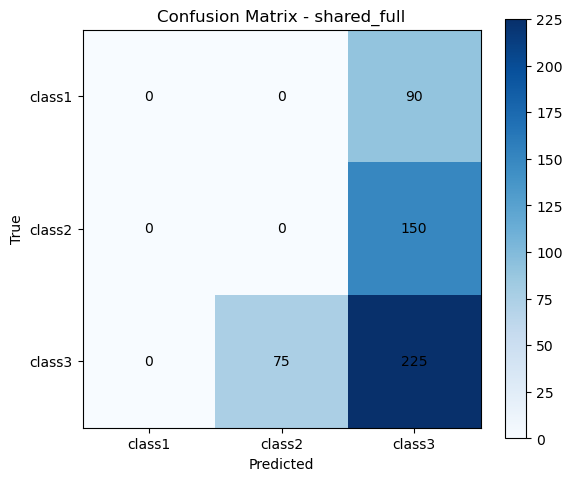

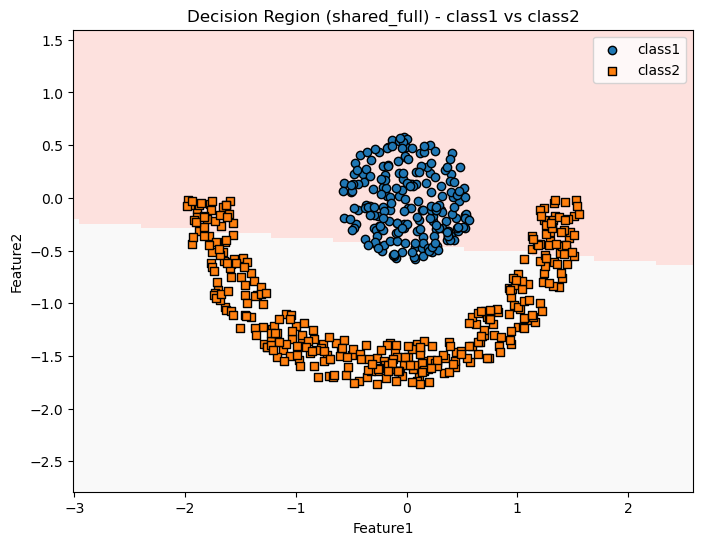

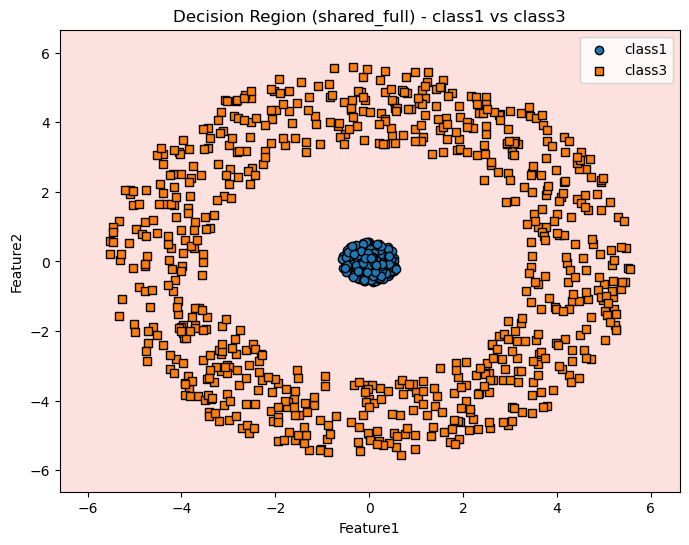

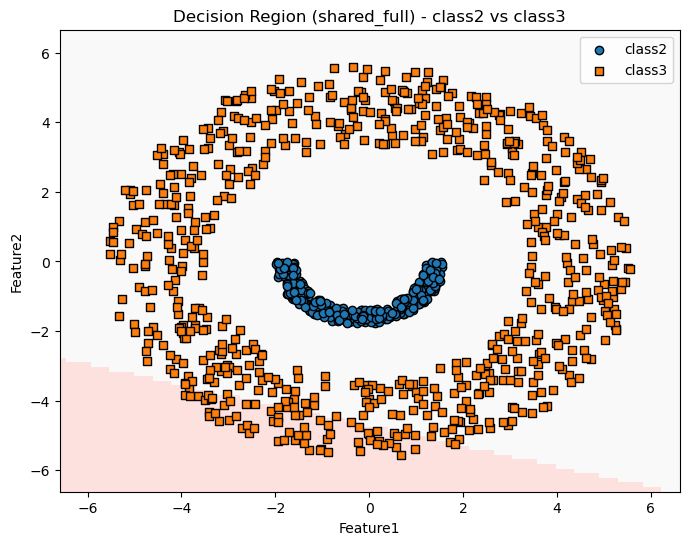

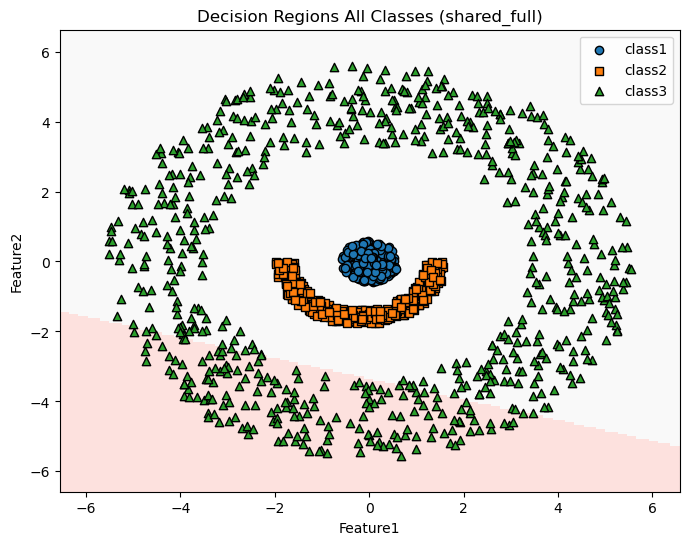



Classifier: diag_per_class

=== Confusion Matrix ===
	class1	class2	class3
class1	90	0	0
class2	0	140	10
class3	0	0	300

=== Classification Report ===
Class	Precision	Recall	F1-score	Support
class1	1.0000		1.0000	1.0000		90
class2	1.0000		0.9333	0.9655		150
class3	0.9677		1.0000	0.9836		300

Accuracy: 0.9815
Mean Precision: 0.9892
Mean Recall   : 0.9778
Mean F1 Score : 0.9830


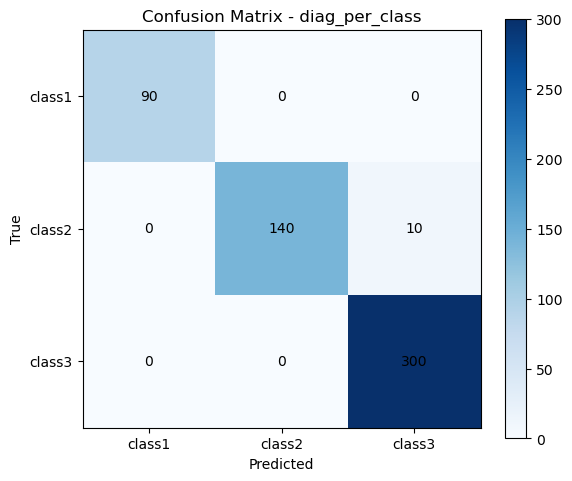

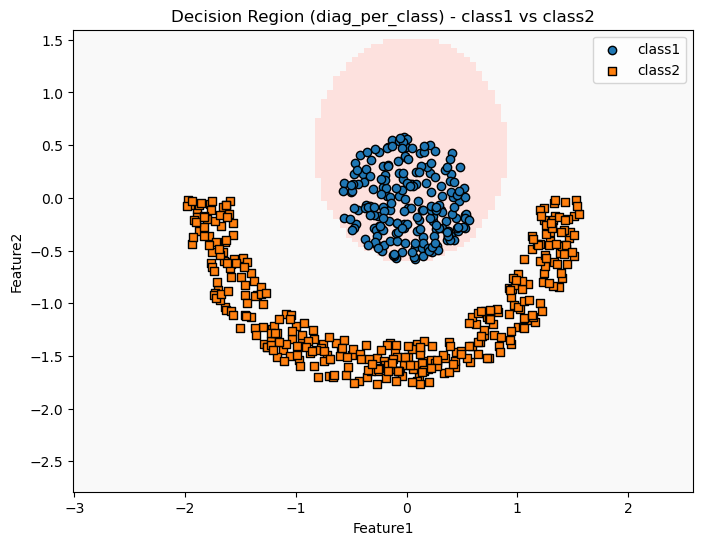

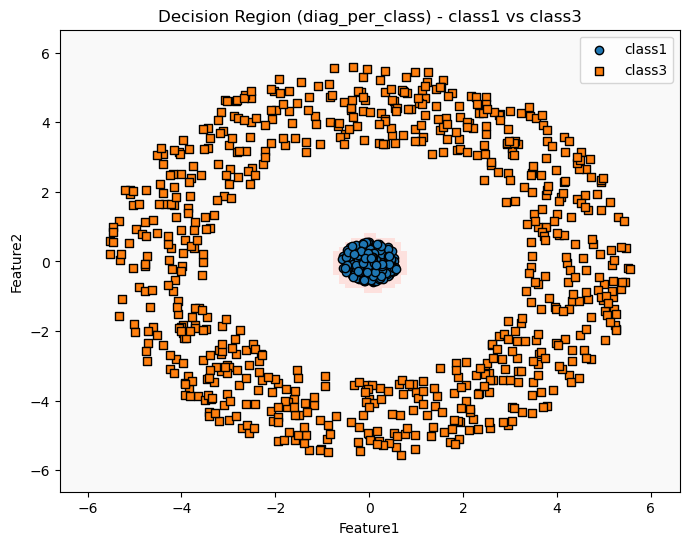

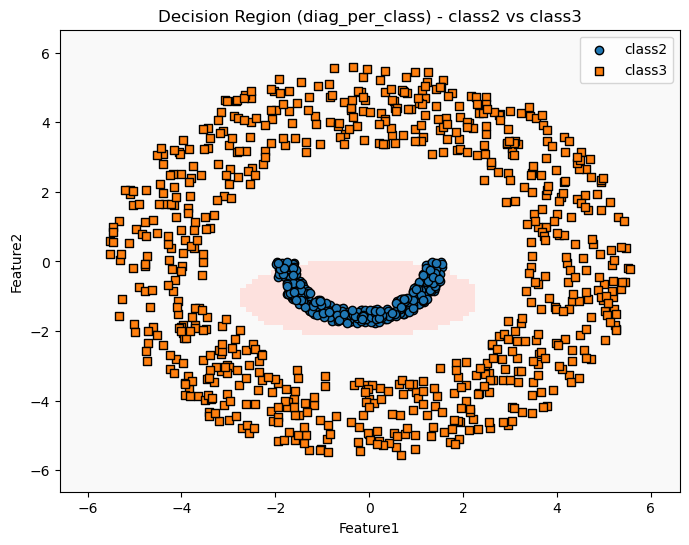

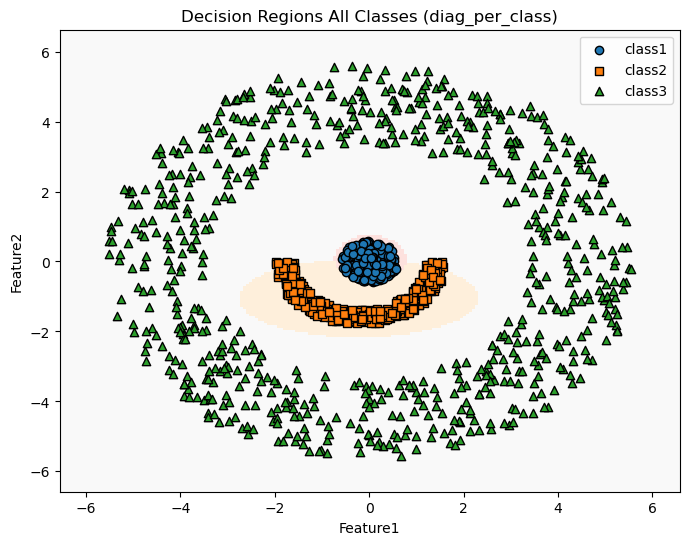



Classifier: full_per_class

=== Confusion Matrix ===
	class1	class2	class3
class1	90	0	0
class2	0	142	8
class3	0	0	300

=== Classification Report ===
Class	Precision	Recall	F1-score	Support
class1	1.0000		1.0000	1.0000		90
class2	1.0000		0.9467	0.9726		150
class3	0.9740		1.0000	0.9868		300

Accuracy: 0.9852
Mean Precision: 0.9913
Mean Recall   : 0.9822
Mean F1 Score : 0.9865


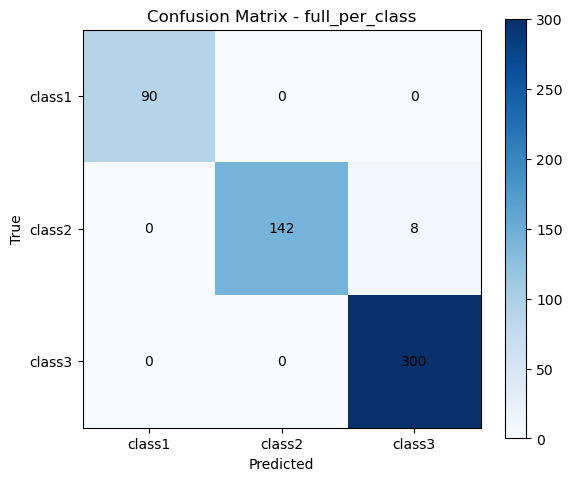

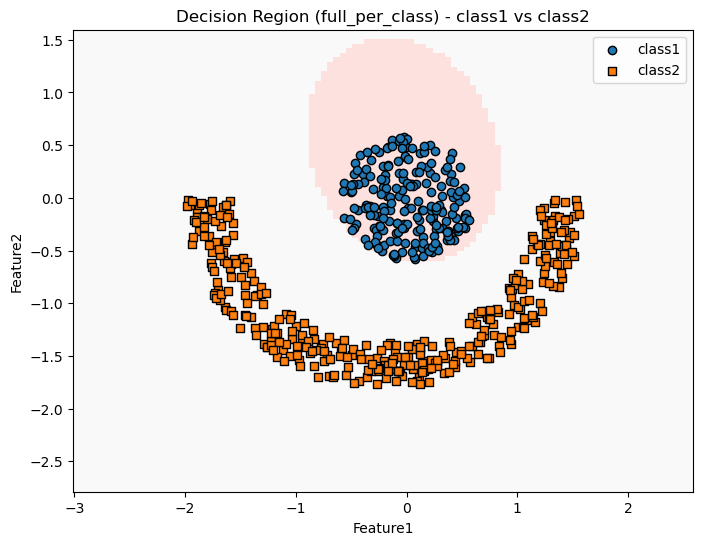

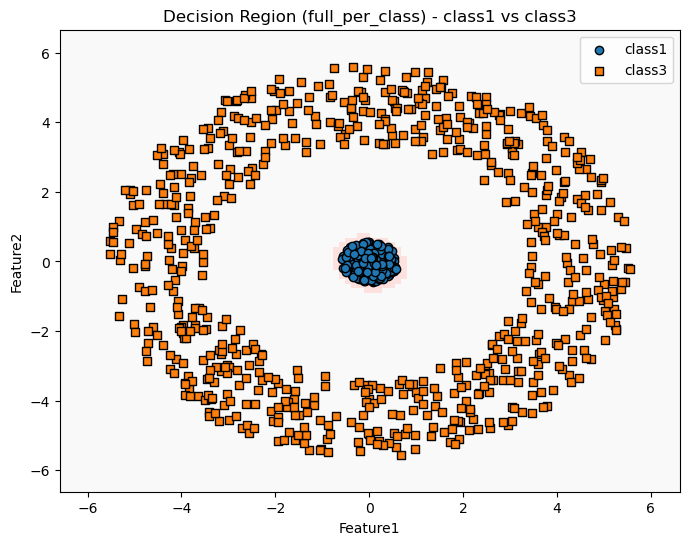

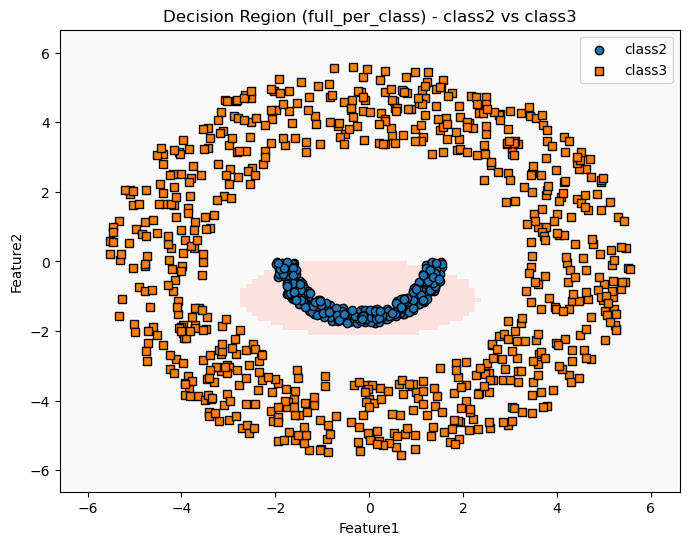

In [11]:
# base_path = "../../Dataset/Group04/LS_Group04/"
base_path = "../../Dataset/Group04/NLS_Group04/"
# base_path = "../../Dataset/Group04/rd_group4/"

train_df, test_df = load_train_test_data(base_path)
run_all(train_df, test_df, res=200)



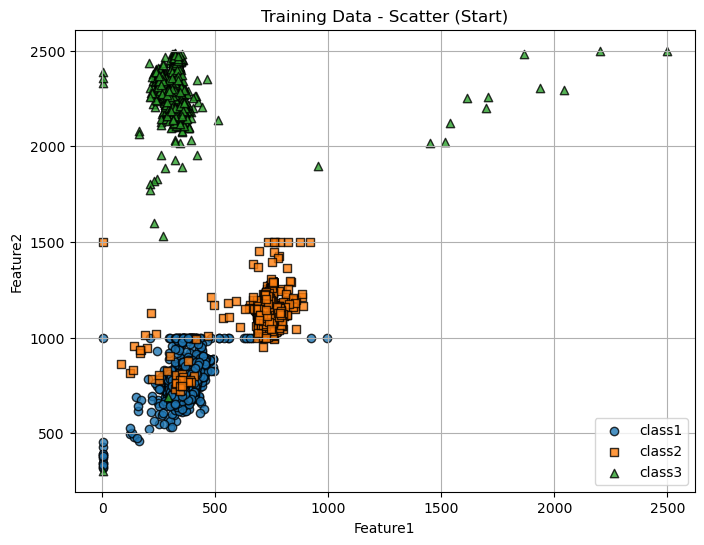

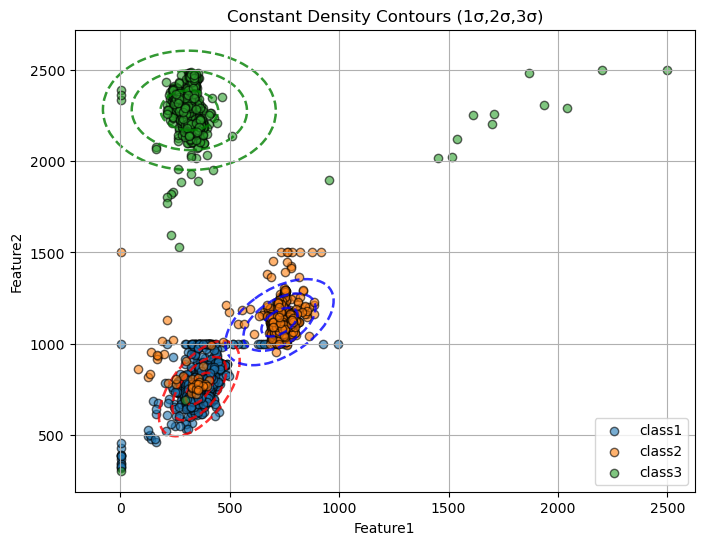



Classifier: sigma2I

=== Confusion Matrix ===
	class1	class2	class3
class1	746	1	0
class2	19	631	0
class3	1	2	714

=== Classification Report ===
Class	Precision	Recall	F1-score	Support
class1	0.9739		0.9987	0.9861		747
class2	0.9953		0.9708	0.9829		650
class3	1.0000		0.9958	0.9979		717

Accuracy: 0.9891
Mean Precision: 0.9897
Mean Recall   : 0.9884
Mean F1 Score : 0.9890


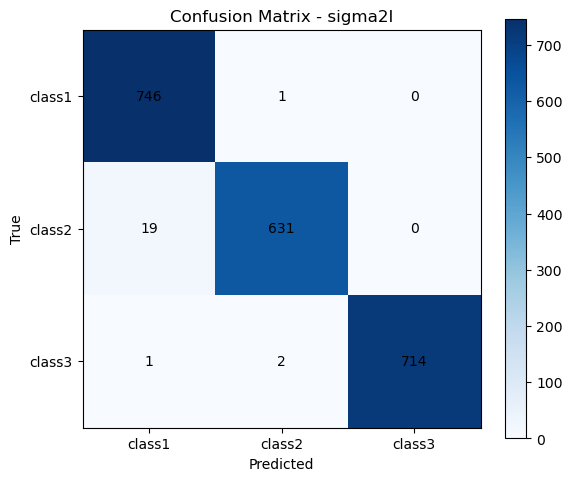

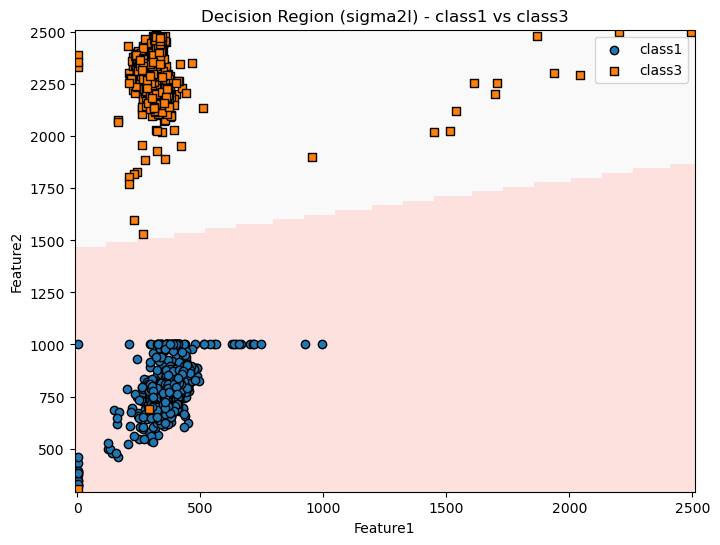

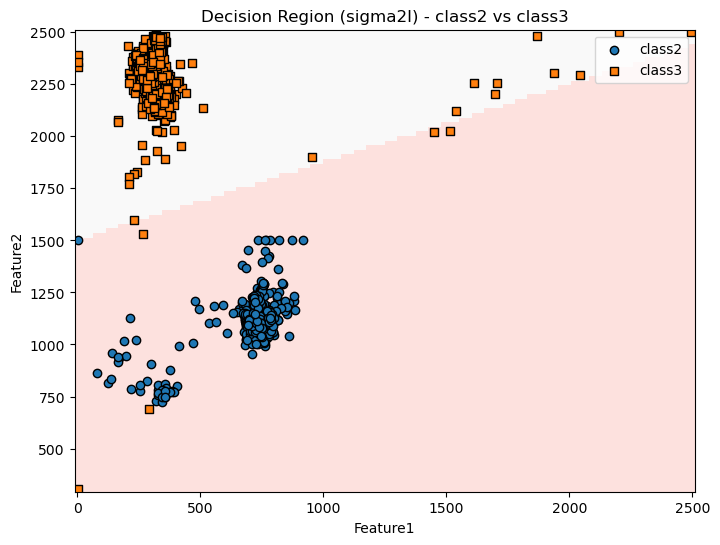

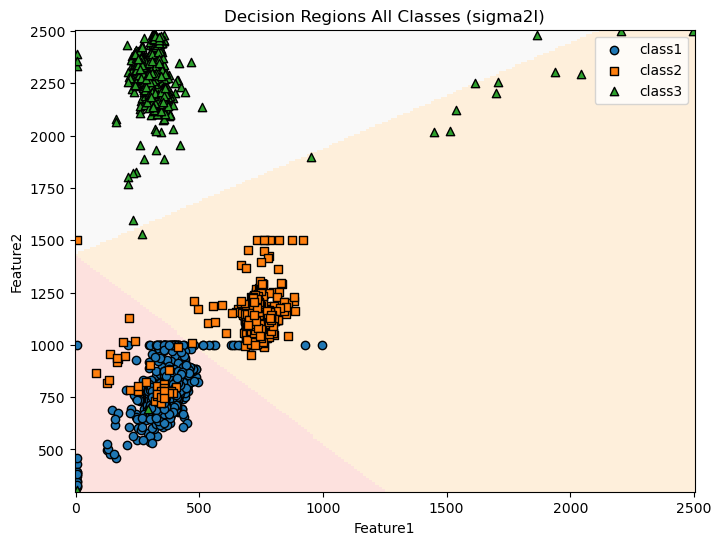



Classifier: shared_full

=== Confusion Matrix ===
	class1	class2	class3
class1	746	1	0
class2	19	631	0
class3	1	4	712

=== Classification Report ===
Class	Precision	Recall	F1-score	Support
class1	0.9739		0.9987	0.9861		747
class2	0.9921		0.9708	0.9813		650
class3	1.0000		0.9930	0.9965		717

Accuracy: 0.9882
Mean Precision: 0.9887
Mean Recall   : 0.9875
Mean F1 Score : 0.9880


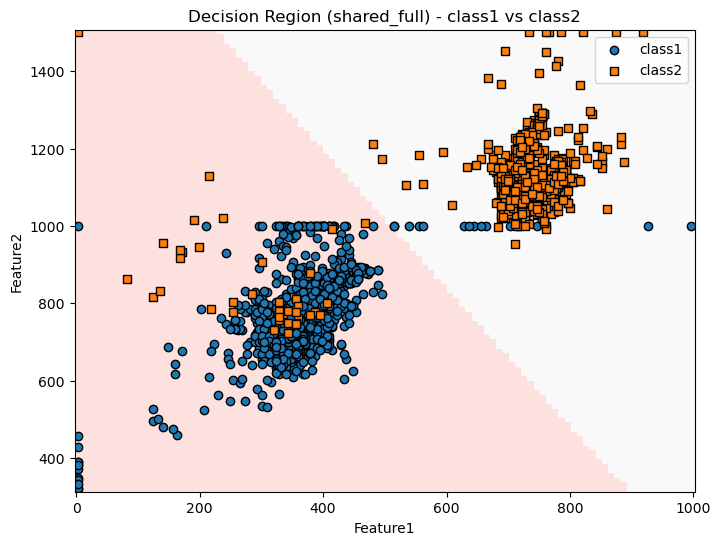

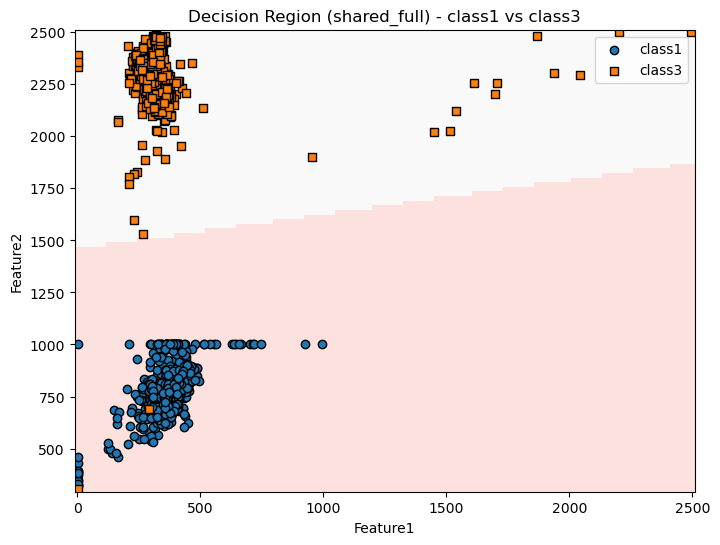

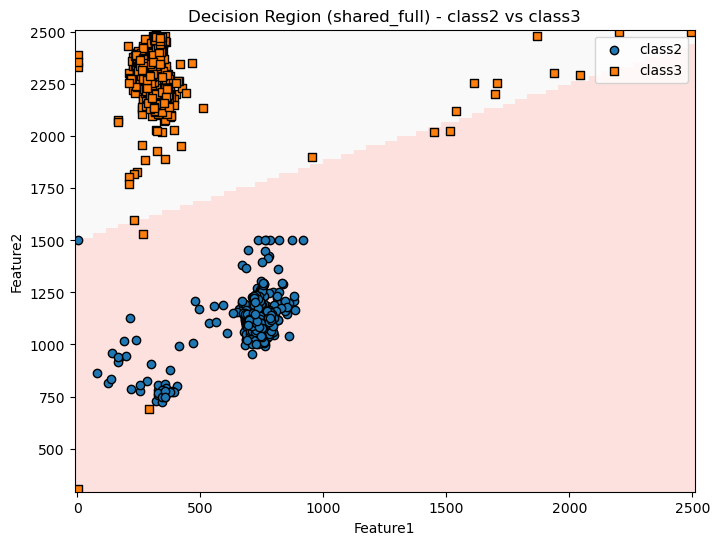

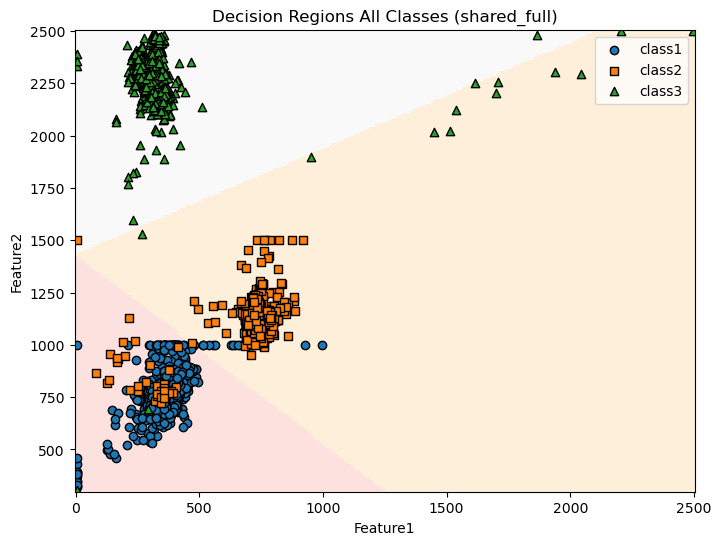



Classifier: diag_per_class

=== Confusion Matrix ===
	class1	class2	class3
class1	746	1	0
class2	19	631	0
class3	1	1	715

=== Classification Report ===
Class	Precision	Recall	F1-score	Support
class1	0.9739		0.9987	0.9861		747
class2	0.9968		0.9708	0.9836		650
class3	1.0000		0.9972	0.9986		717

Accuracy: 0.9896
Mean Precision: 0.9902
Mean Recall   : 0.9889
Mean F1 Score : 0.9895


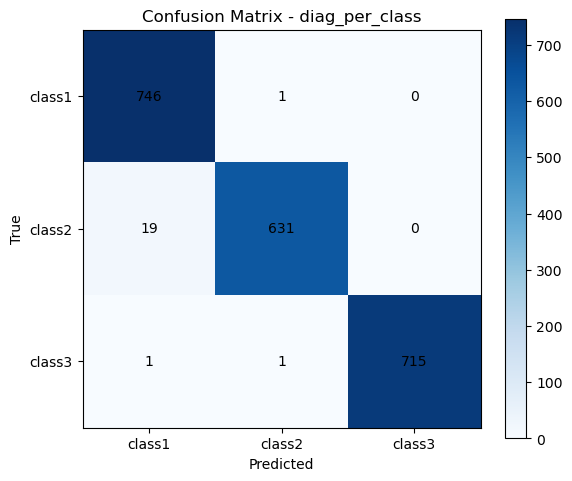

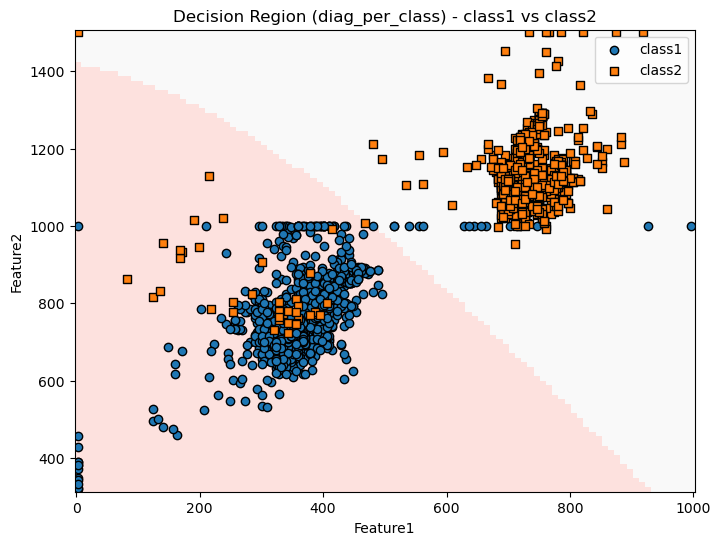

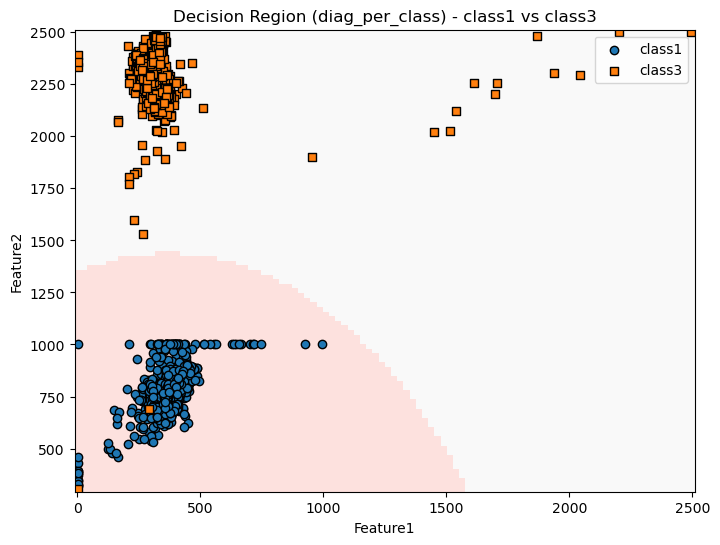

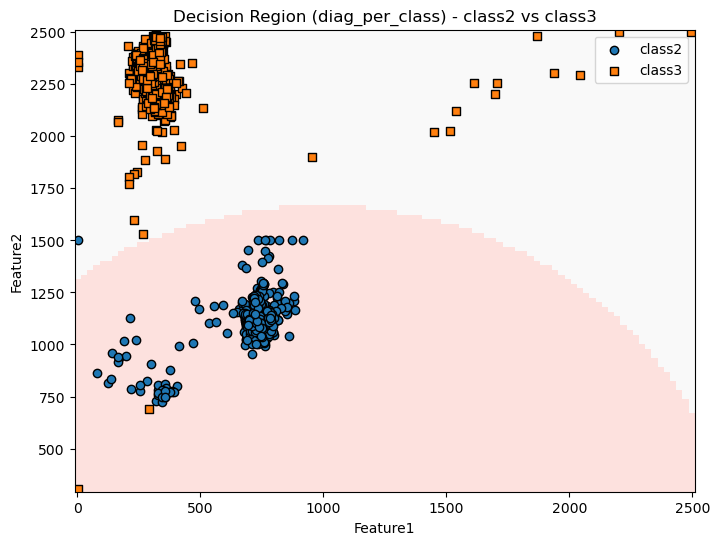

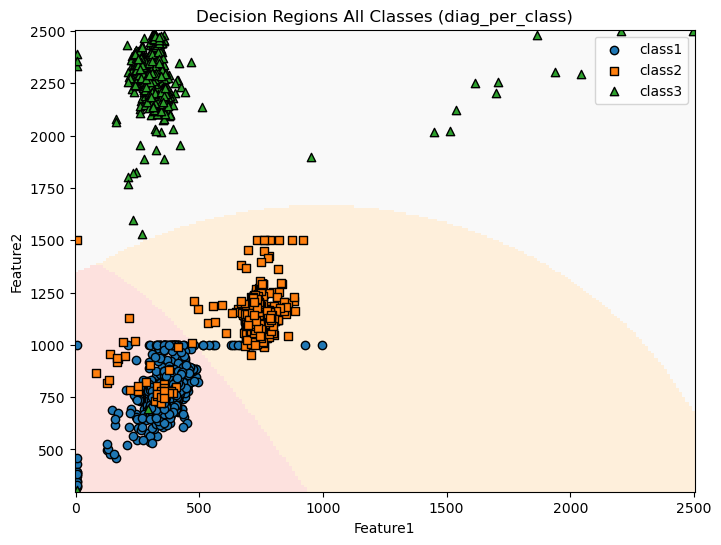



Classifier: full_per_class

=== Confusion Matrix ===
	class1	class2	class3
class1	745	2	0
class2	19	631	0
class3	1	1	715

=== Classification Report ===
Class	Precision	Recall	F1-score	Support
class1	0.9739		0.9973	0.9854		747
class2	0.9953		0.9708	0.9829		650
class3	1.0000		0.9972	0.9986		717

Accuracy: 0.9891
Mean Precision: 0.9897
Mean Recall   : 0.9884
Mean F1 Score : 0.9890


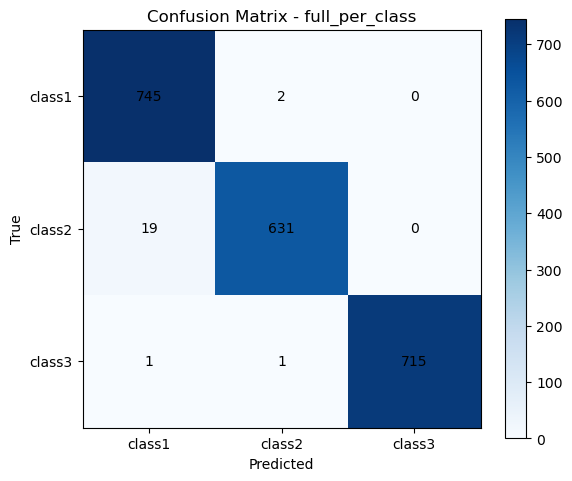

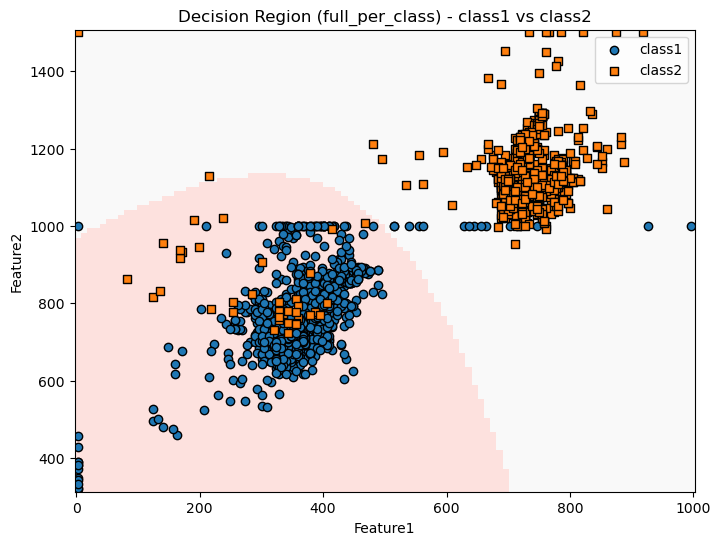

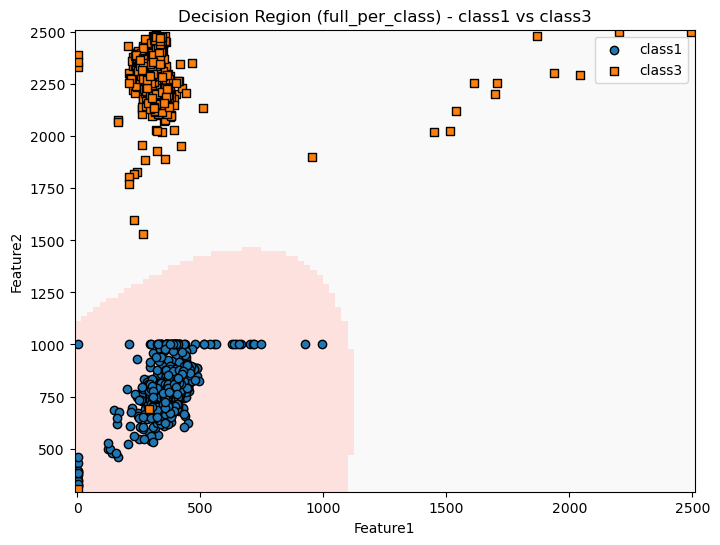

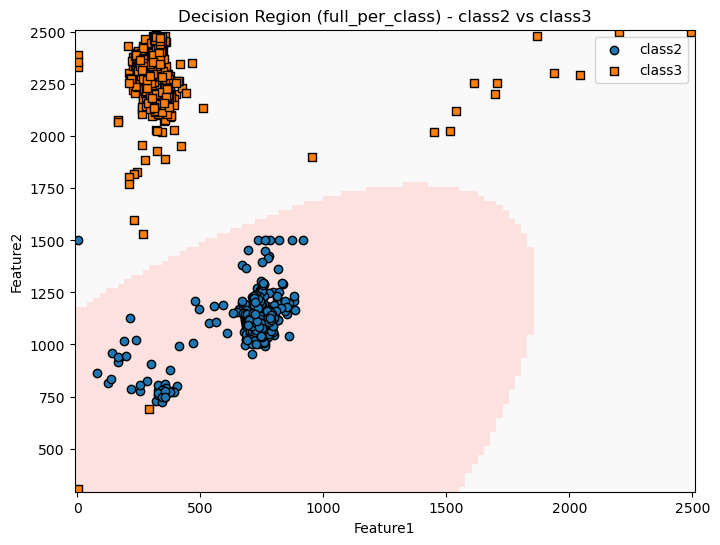

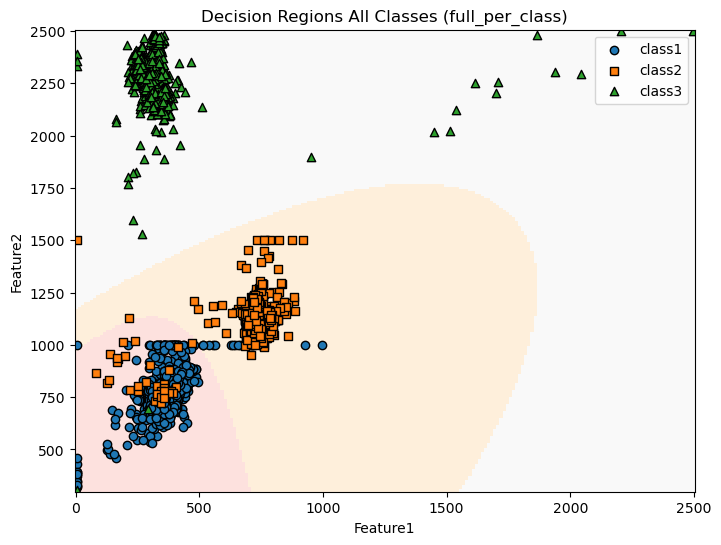

In [12]:
# base_path = "../../Dataset/Group04/LS_Group04/"
# base_path = "../../Dataset/Group04/NLS_Group04/"
base_path = "../../Dataset/Group04/rd_group4/"

train_df, test_df = load_train_test_data(base_path)
run_all(train_df, test_df, res=200)